In [2]:
%load_ext autoreload

In [3]:
%autoreload 2
%matplotlib inline

In [4]:
import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import auc, roc_auc_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split

from SepMe.processing.batchprocessing import *

import warnings
warnings.filterwarnings('ignore')

SepMe - INFO - MLFLOW_TRACKING_URI - http://localhost:5000


In [45]:
df = pd.read_csv('lazy_all.csv')
print(df.shape)

df['human_bin'] = 'no'
df.loc[(df['human_rating'].between(50,100)), 'human_bin'] = 'yes'

df['expert_bin'] = 'maybe'
df.loc[(df['M'].isin([4,5])) & (df['A'].isin([4,5])), 'expert_bin'] = 'yes'
df.loc[(df['M'].isin([1,2])) & (df['A'].isin([1,2])), 'expert_bin'] = 'no'



#df['M'] = minmax_scale(df['M'])
#df['A'] = minmax_scale(df['A'])
df['human_rating'] = minmax_scale(df['human_rating'])


df = df.loc[df['1v1']==False]
print(df.shape)
df = df.loc[df['pass']==1]
df


df['consensus'] = 'no'
df.loc[(df['human_bin']=='yes') & (df['expert_bin']=='yes'), 'consensus'] = 'yes'
df.loc[(df['human_bin']=='no') & (df['expert_bin']=='no'), 'consensus'] = 'yes'
print(df['consensus'].value_counts())
print(df.shape)

df.to_csv('help_me_god_please.csv', index=False)

(28205, 66)
(16277, 68)
yes    8503
no     5892
Name: consensus, dtype: int64
(14395, 69)


In [22]:
#reproducing old sepme
import scikitplot as skplt
import matplotlib.pyplot as plt
import random
from scipy.stats import sem, t
from scipy import mean
confidence = 0.95


def bootstrap_aoc(df, bs=100, sample=1000, target_col='human_bin'):
    
    aucs = {}
    for col in df.columns[7:-2]:

        if df[col].dtype =='float64':
            #print(col)
            df.loc[:, 'a'] = 1 - df[col]
            a = np.array(df.loc[:,target_col].copy())
            b = np.array(df.loc[:, 'a'].copy())

            stuff =[]
            for i in range(bs):
                idx = random.sample(list(np.arange(len(a))),sample)
                stuff.append(roc_auc_score(a[idx],b[idx]))

            n = len(stuff)
            m = mean(stuff)
            std_err = sem(stuff)
            h = std_err * t.ppf((1 + confidence) / 2, n - 1)

            aucs[col] = {}
            aucs[col]['mean'] = m
            aucs[col]['start'] = m-h
            aucs[col]['end'] = m+h
            
            if aucs[col]['mean']>.84:
                #print(b)
                b = np.array(df.loc[:, [col,'a']].copy())
                skplt.metrics.plot_roc(a,b)
                plt.show()



    aucs = pd.DataFrame.from_dict(aucs, orient='index').reset_index()
    aucs.columns = ['type','value','ci-','ci+'] 
    aucs = aucs.sort_values('value', ascending=False)
    aucs['spread'] = aucs['ci+'] -aucs['ci-']
    return aucs


(7323, 69)


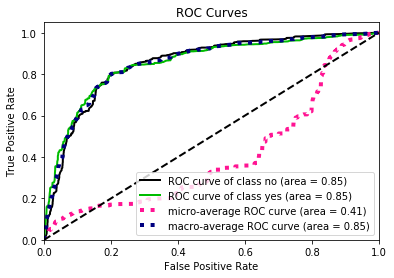

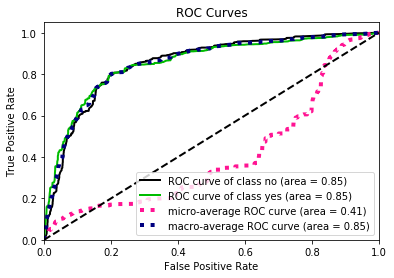

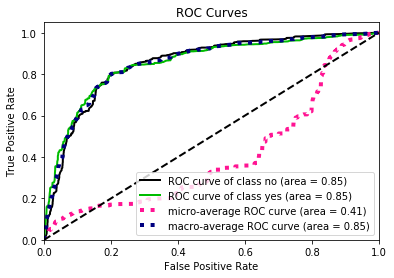

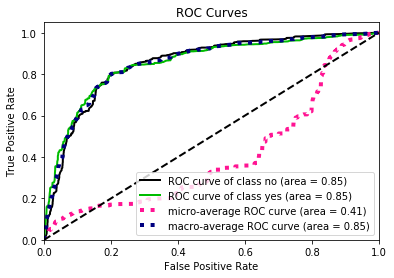

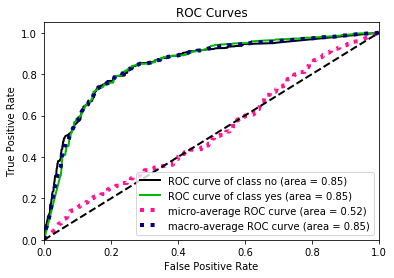

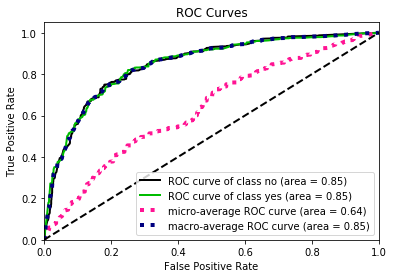

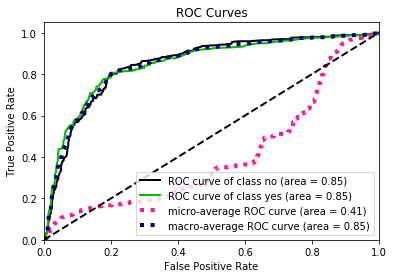

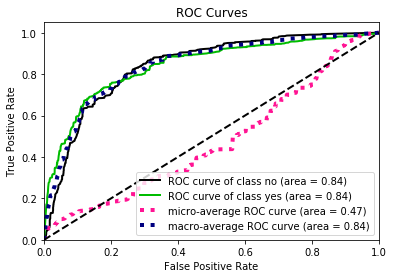

,type,value,ci-,ci+,spread
6,as_0.1_ce,0.856278,0.853085,0.859472,0.006387
0,as_0.02_ce,0.854493,0.851632,0.857354,0.005722
3,as_0.05_ce,0.852924,0.849994,0.855855,0.005861
9,as_0.5_ce,0.851203,0.848197,0.854209,0.006013
14,bt_0.05_ce,0.848646,0.845708,0.851585,0.005877
17,bt_0.1_ce,0.848480,0.845363,0.851597,0.006234
35,del_n/a_ce,0.847833,0.845014,0.850652,0.005638
49,knn_6.0_ce,0.841675,0.838608,0.844742,0.006134
46,knn_4.0_ce,0.838659,0.835648,0.841670,0.006021
43,knn_2.0_ce,0.837189,0.834227,0.840152,0.005925


In [23]:
# df_exp = df.loc[(df['expert_bin'].isin(['yes','no']))]
# print(df_exp.shape)
# aucs_human = bootstrap_aoc(df_exp, target_col='expert_bin')
# aucs_human.head(20)

# df_bin = df.loc[(df['human_rating'].between(0,.30)) | (df['human_rating'].between(.90,1.00))]
# print(df_bin.shape)
# aucs_human = bootstrap_aoc(df_bin, target_col='human_bin')
# aucs_human.head(20)

In [31]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.tree.export import export_text
from sklearn import tree
import graphviz 

In [37]:
cross_val_score(decision_tree, np.array(df[['human_rating']]), np.array(df[['M']]), cv=10)

array([0.36179361, 0.39312039, 0.45823096, 0.32063882, 0.4004914 ,
       0.38329238, 0.39742015, 0.37062077, 0.4105716 , 0.37922557])

|--- human_rating <= 0.72
|   |--- human_rating <= 0.15
|   |   |--- human_rating <= 0.06
|   |   |   |--- class: 1
|   |   |--- human_rating >  0.06
|   |   |   |--- class: 1
|   |--- human_rating >  0.15
|   |   |--- human_rating <= 0.34
|   |   |   |--- human_rating <= 0.23
|   |   |   |   |--- class: 1
|   |   |   |--- human_rating >  0.23
|   |   |   |   |--- class: 2
|   |   |--- human_rating >  0.34
|   |   |   |--- human_rating <= 0.62
|   |   |   |   |--- human_rating <= 0.50
|   |   |   |   |   |--- class: 4
|   |   |   |   |--- human_rating >  0.50
|   |   |   |   |   |--- class: 3
|   |   |   |--- human_rating >  0.62
|   |   |   |   |--- human_rating <= 0.67
|   |   |   |   |   |--- class: 4
|   |   |   |   |--- human_rating >  0.67
|   |   |   |   |   |--- class: 4
|--- human_rating >  0.72
|   |--- human_rating <= 0.87
|   |   |--- human_rating <= 0.78
|   |   |   |--- class: 5
|   |   |--- human_rating >  0.78
|   |   |   |--- class: 5
|   |--- human_rating >  0.87
|   

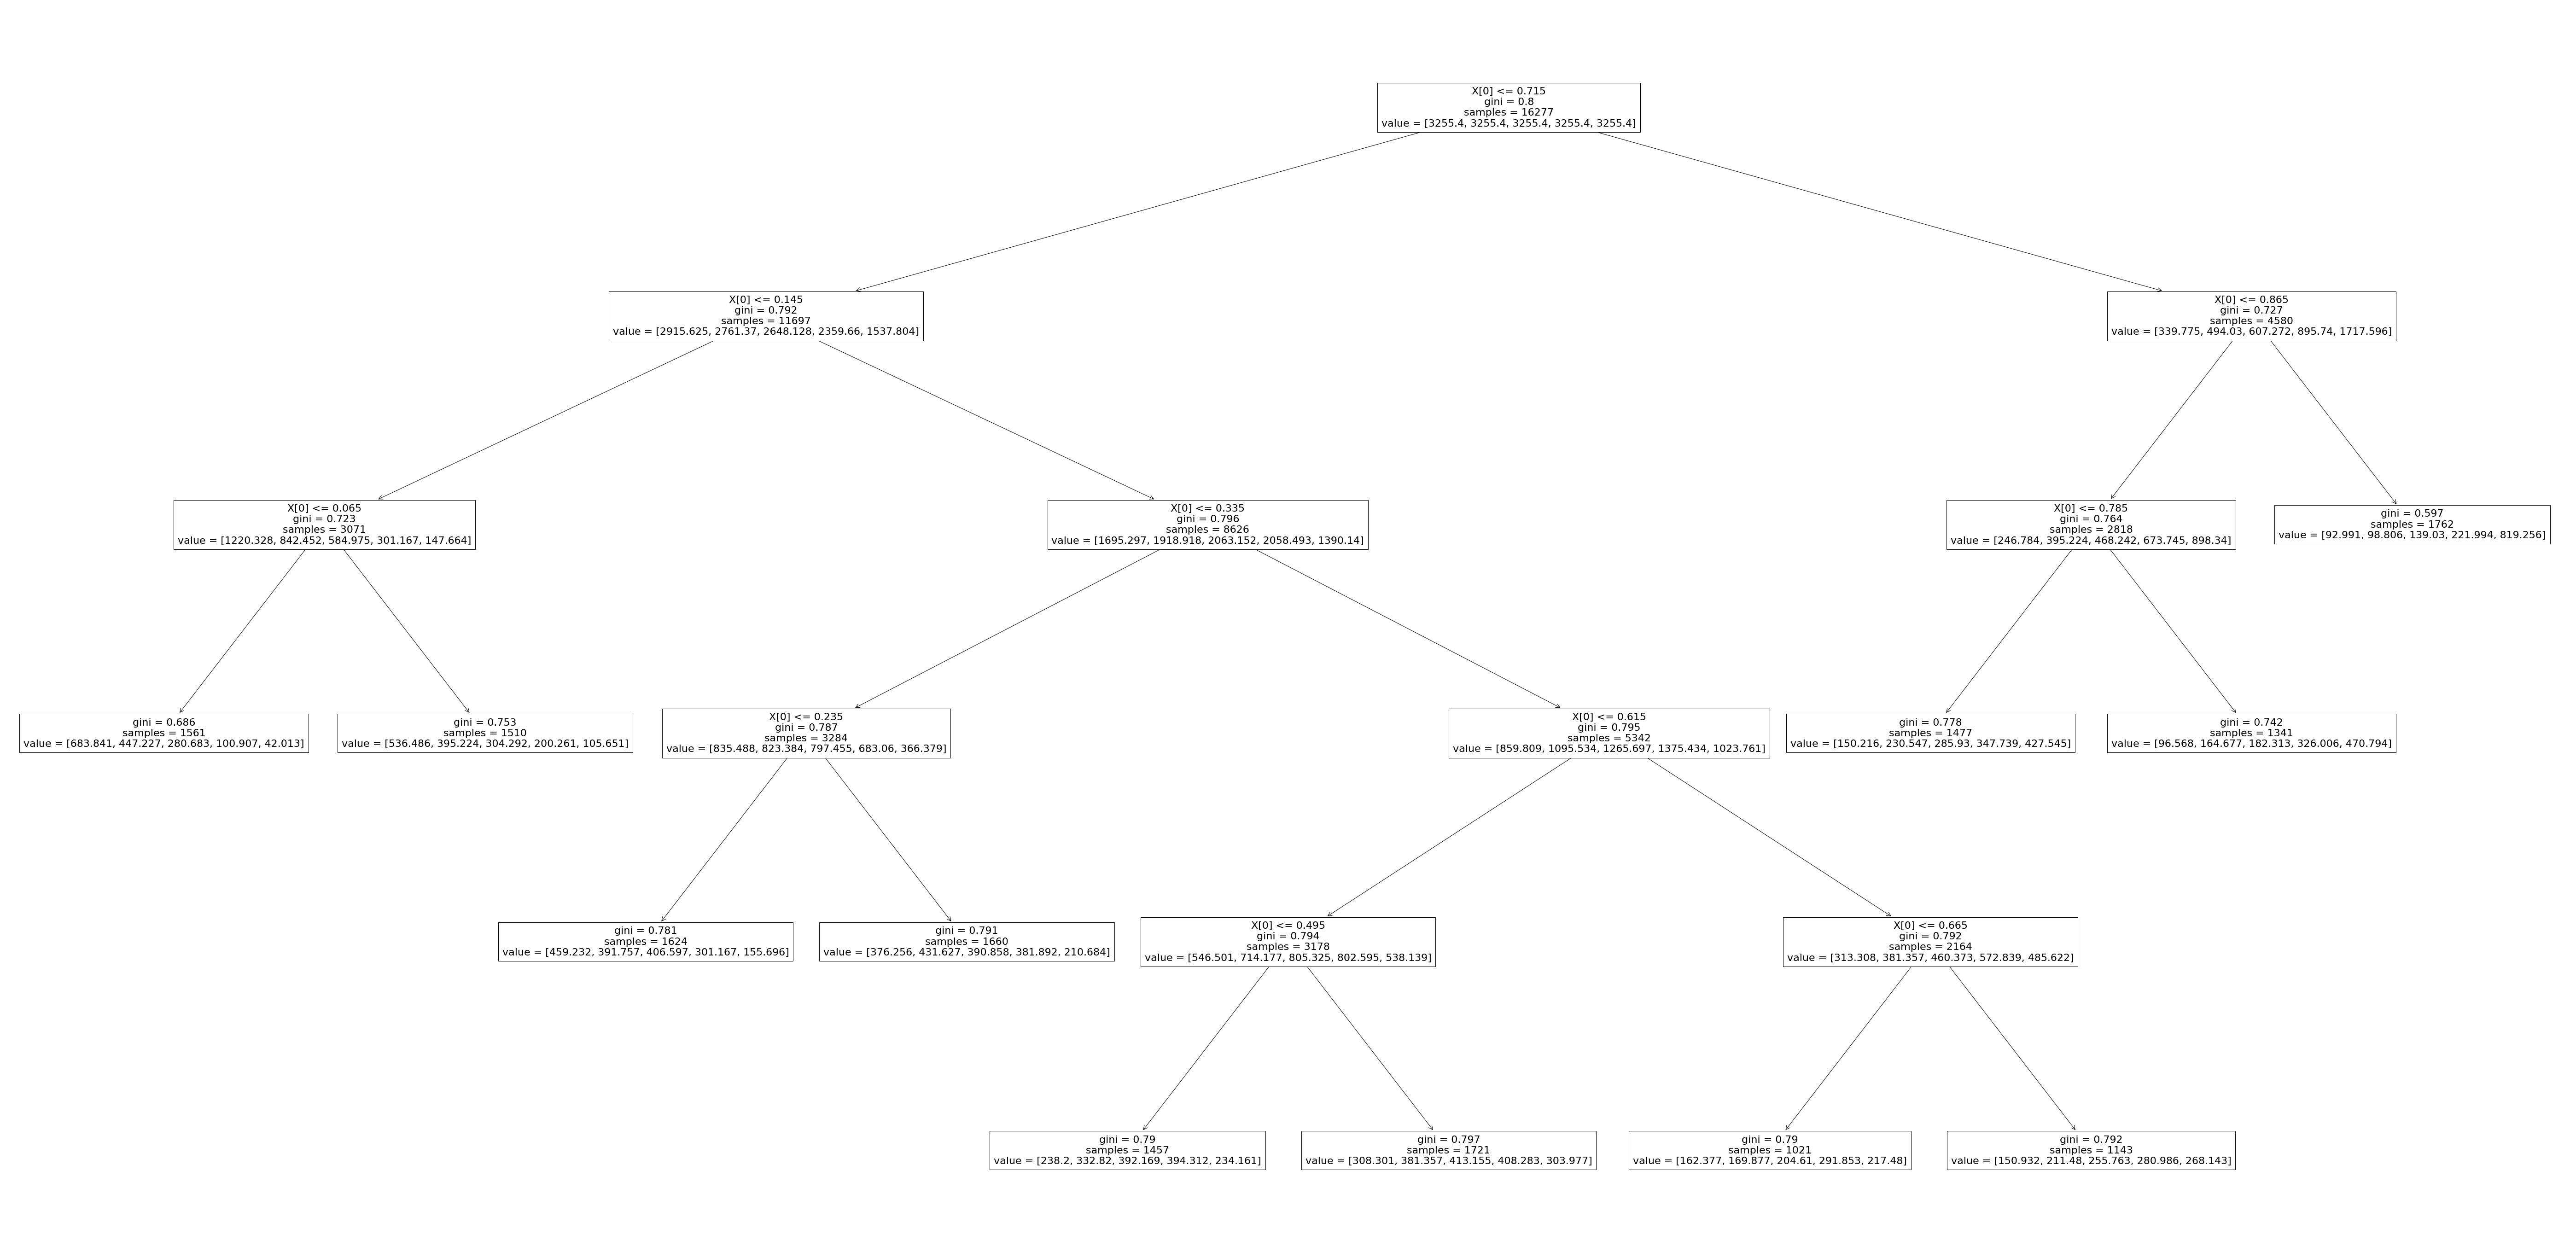

In [36]:

decision_tree = DecisionTreeClassifier(random_state=0, max_depth=5, class_weight='balanced',min_samples_leaf=1000)
decision_tree = decision_tree.fit(np.array(df[['human_rating']]), np.array(df[['M']]))
r = export_text(decision_tree, feature_names=['human_rating'])


fig, ax = plt.subplots(figsize=(100,50))
tree.plot_tree(decision_tree) 

print(r)






|--- human_rating <= 0.34
|   |--- human_rating <= 0.13
|   |   |--- human_rating <= 0.06
|   |   |   |--- value: [1.74]
|   |   |--- human_rating >  0.06
|   |   |   |--- value: [2.15]
|   |--- human_rating >  0.13
|   |   |--- human_rating <= 0.23
|   |   |   |--- value: [2.48]
|   |   |--- human_rating >  0.23
|   |   |   |--- value: [2.78]
|--- human_rating >  0.34
|   |--- human_rating <= 0.75
|   |   |--- human_rating <= 0.64
|   |   |   |--- human_rating <= 0.52
|   |   |   |   |--- human_rating <= 0.41
|   |   |   |   |   |--- value: [3.05]
|   |   |   |   |--- human_rating >  0.41
|   |   |   |   |   |--- value: [3.08]
|   |   |   |--- human_rating >  0.52
|   |   |   |   |--- value: [3.21]
|   |   |--- human_rating >  0.64
|   |   |   |--- human_rating <= 0.69
|   |   |   |   |--- value: [3.42]
|   |   |   |--- human_rating >  0.69
|   |   |   |   |--- value: [3.56]
|   |--- human_rating >  0.75
|   |   |--- human_rating <= 0.83
|   |   |   |--- value: [3.86]
|   |   |--- hum

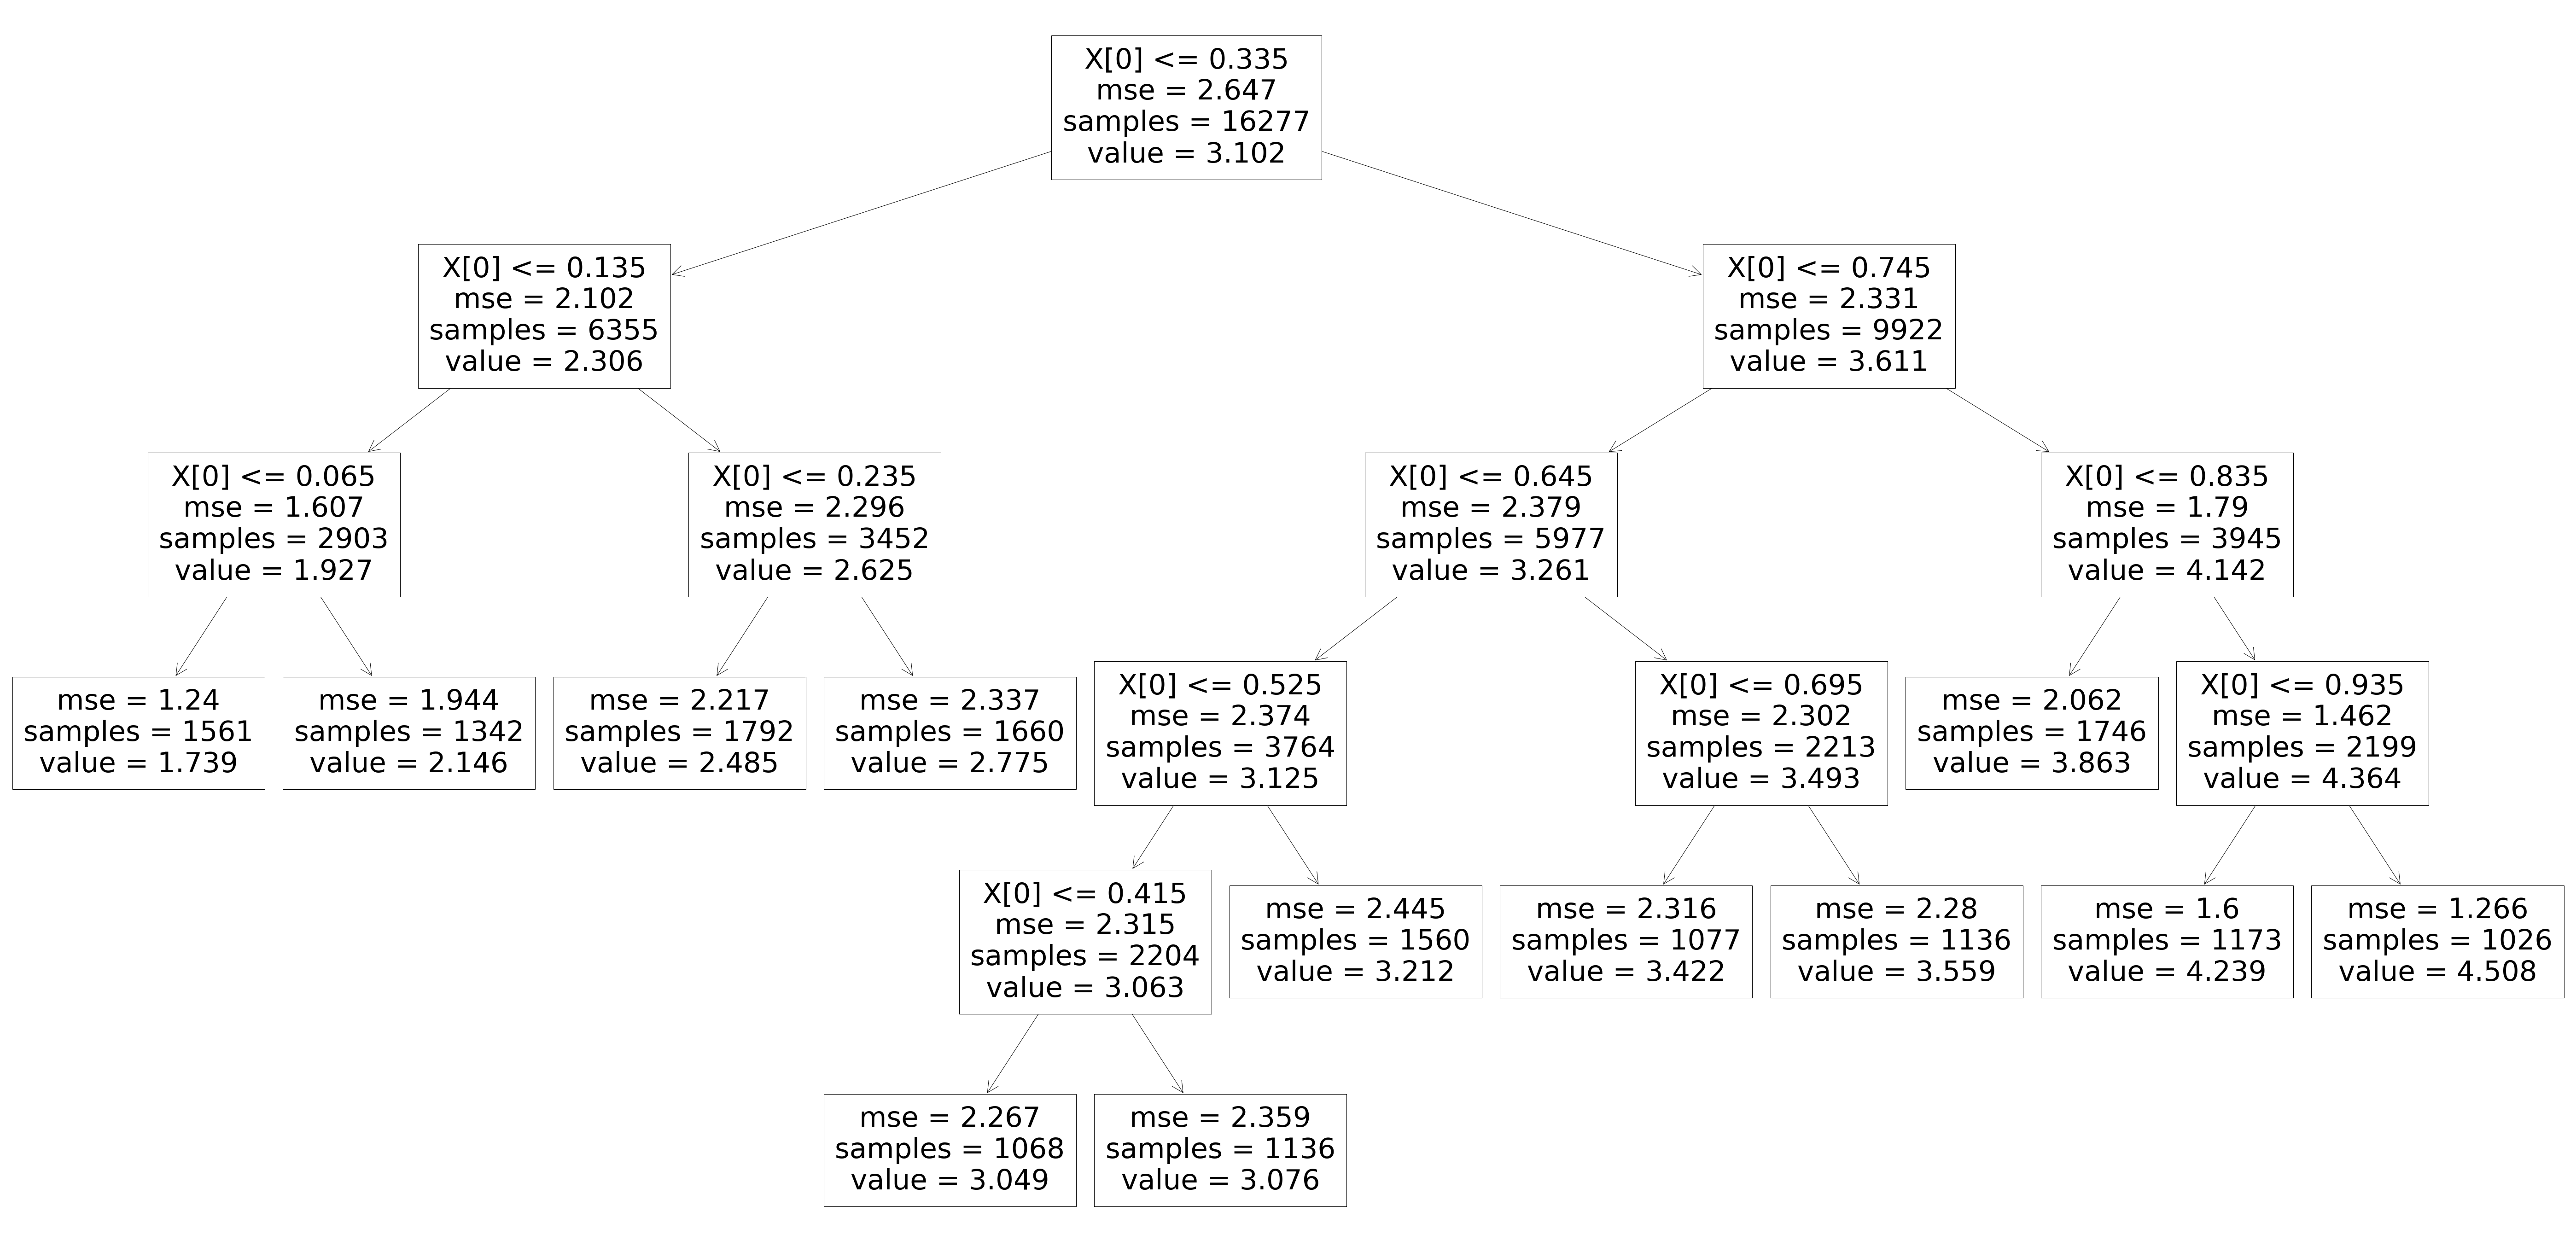

In [38]:

decision_tree = DecisionTreeRegressor(random_state=0, max_depth=5,
                                      min_samples_leaf=1000)
decision_tree = decision_tree.fit(np.array(df[['human_rating']]), np.array(df[['M']]))
r = export_text(decision_tree, feature_names=['human_rating'])


fig, ax = plt.subplots(figsize=(100,50))
tree.plot_tree(decision_tree) 

print(r)




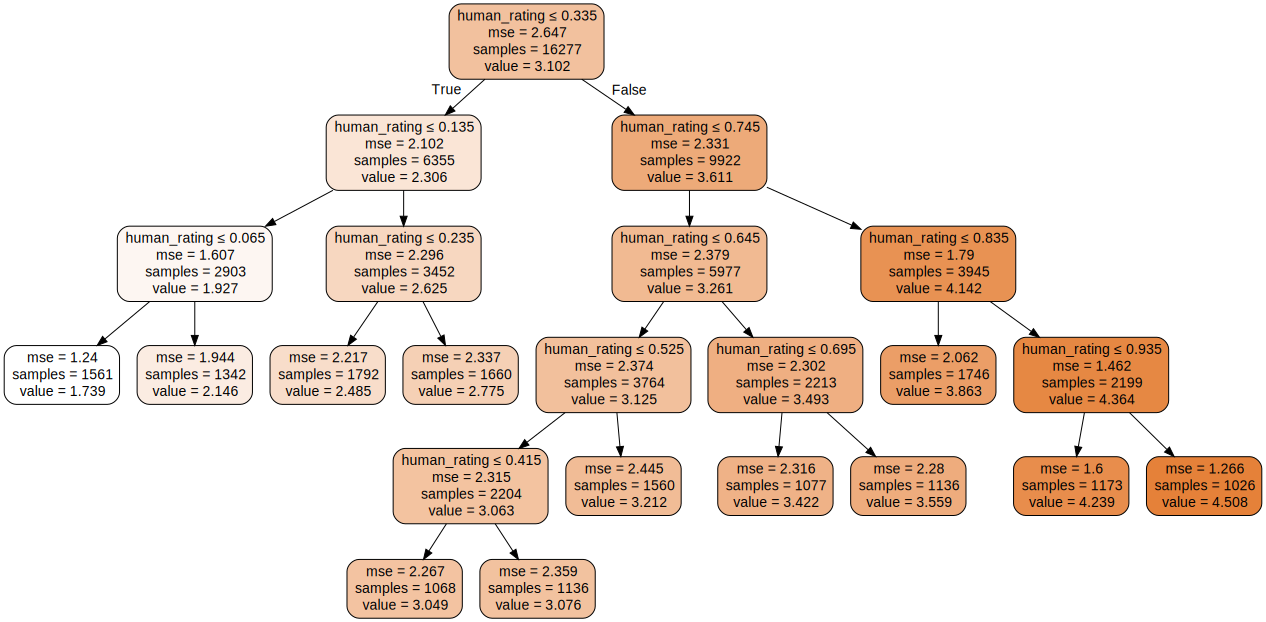

In [34]:

dot_data = tree.export_graphviz(decision_tree, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("df") 

dot_data = tree.export_graphviz(decision_tree, out_file=None, 
                     feature_names=['human_rating'],  

                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

In [1]:
class OrdinalClassifier():
    
    def __init__(self, clf):
        self.clf = clf
        self.clfs = {}
    
    def fit(self, X, y):
        self.unique_class = np.sort(np.unique(y))
        if self.unique_class.shape[0] > 2:
            for i in range(self.unique_class.shape[0]-1):
                # for each k - 1 ordinal value we fit a binary classification problem
                binary_y = (y > self.unique_class[i]).astype(np.uint8)
                clf = clone(self.clf)
                clf.fit(X, binary_y)
                self.clfs[i] = clf
    
    def predict_proba(self, X):
        clfs_predict = {k:self.clfs[k].predict_proba(X) for k in self.clfs}
        predicted = []
        for i,y in enumerate(self.unique_class):
            if i == 0:
                # V1 = 1 - Pr(y > V1)
                predicted.append(1 - clfs_predict[y][:,1])
            elif y in clfs_predict:
                # Vi = Pr(y > Vi-1) - Pr(y > Vi)
                 predicted.append(clfs_predict[y-1][:,1] - clfs_predict[y][:,1])
            else:
                # Vk = Pr(y > Vk-1)
                predicted.append(clfs_predict[y-1][:,1])
        return np.vstack(predicted).T
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

In [39]:
import xgboost as xgb
from sklearn.metrics import explained_variance_score

df['type_bool'] = False
df.loc[df['type']=='semantic','type_bool'] = True

df['phase_bool'] = False
df.loc[df['phase']=='semantic','phase_bool'] = True



x_cols = ['type_bool',  'phase_bool','pass', 'as_0.02_ce', 'as_0.02_cp', 'as_0.02_ltcc', 'as_0.05_ce', 'as_0.05_cp',
       'as_0.05_ltcc', 'as_0.1_ce', 'as_0.1_cp', 'as_0.1_ltcc', 'as_0.5_ce',
       'as_0.5_cp', 'as_0.5_ltcc', 'bt_0.02_cp', 'bt_0.02_ltcc', 'bt_0.05_ce',
       'bt_0.05_cp', 'bt_0.05_ltcc', 'bt_0.1_ce', 'bt_0.1_cp', 'bt_0.1_ltcc',
       'bt_0.5_ce', 'bt_0.5_cp', 'bt_0.5_ltcc', 'cbsg_0.1_ce', 'cbsg_0.1_cp',
       'cbsg_0.1_ltcc', 'cbsg_0.2_ce', 'cbsg_0.2_cp', 'cbsg_0.2_ltcc',
       'cbsg_0.5_ce', 'cbsg_0.5_cp', 'cbsg_0.5_ltcc', 'cbsg_2.0_ce',
       'cbsg_2.0_cp', 'cbsg_2.0_ltcc', 'del_n/a_ce', 'del_n/a_cp',
       'del_n/a_ltcc', 'del_n/a_mv_false', 'del_n/a_mv_true', 'knn_1.0_ce',
       'knn_1.0_cp', 'knn_1.0_ltcc', 'knn_2.0_ce', 'knn_2.0_cp',
       'knn_2.0_ltcc', 'knn_4.0_ce', 'knn_4.0_cp', 'knn_4.0_ltcc',
       'knn_6.0_ce', 'knn_6.0_cp', 'knn_6.0_ltcc', 'knn_8.0_ce', 'knn_8.0_cp',
       'knn_8.0_ltcc']

y = ['human_rating' , 'M']




X_train, X_test, Y_train, Y_test = train_test_split(df[x_cols], df[y[0]], test_size=0.2, stratify=df['filename'])

D_train = xgb.DMatrix(X_train, label=Y_train)
D_test = xgb.DMatrix(X_test, label=Y_test)

param = {
    'eta': 0.3, 
    'max_depth': 30,  
    'objective': 'multi:softprob',  
    'num_class': 3} 

steps = 20  # The number of training iterations

model = xgb.train(param, D_train, steps)



preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

# print("Precision = {}".format(precision_score(Y_test, best_preds, average='macro')))
# print("Recall = {}".format(recall_score(Y_test, best_preds, average='macro')))
# print("Accuracy = {}".format(accuracy_score(Y_test, best_preds)))

In [40]:
preds

array([[0.33088878, 0.35056707, 0.31854418],
       [0.22689573, 0.55356133, 0.21954294],
       [0.36067027, 0.3229066 , 0.31642315],
       ...,
       [0.33630162, 0.33994326, 0.3237551 ],
       [0.3406544 , 0.35258436, 0.3067612 ],
       [0.33606943, 0.3412436 , 0.32268697]], dtype=float32)

In [ ]:
from sklearn.model_selection import GridSearchCV

clf = xgb.XGBRegressor()
parameters = {
     "n_estimators"    : [10, 50,100,250] ,
     "max_depth"        : [ 5,  8, 10, 15],
     "learning_rate" : [0.01, 0.02, 0.05, 0.1],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.4 ],
     "colsample_bytree" : [ 0.4, 0.5]
     }

grid = GridSearchCV(clf,
                    parameters, n_jobs=-1,
                    scoring="neg_mean_squared_error",
                    cv=3, verbose=5)

grid.fit(X_train, Y_train)

Fitting 3 folds for each of 2048 candidates, totalling 6144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 10.2min


In [32]:
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7, verbosity=3)

model.fit(X_train, Y_train)



[00:54:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:54:30] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=7
[00:54:30] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=7
[00:54:30] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=7
[00:54:30] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=7
[00:54:30] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=7
[00:54:30] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=7
[00:54:31] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=7
[00:54:31] INFO: src/tree/updater_prune.cc:74: tree

[00:54:37] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=7
[00:54:37] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=7
[00:54:37] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=7
[00:54:37] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=7
[00:54:37] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=7
[00:54:38] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=7
[00:54:38] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=7
[00:54:38] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=7
[00:54:38] INFO: src/tree/updater_prune.cc:74: t

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.08, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.75, verbosity=3)

In [33]:
predictions = model.predict(X_test)
print(explained_variance_score(predictions,Y_test))

0.11664433766424143


In [38]:
import sklearn.metrics as sm

sm.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])